In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process the diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from functions import (wls_fit_tensor, nlls_fit_tensor)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Parameters of the 7x12 full acquisitions
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
bmin = np.linspace(200, 800, num=7)
bmax = np.linspace(300, 1500, num=13)

# SNR is adjusted as function of bmax
SNR = 15.0
T2 = 70.0
TE = np.array([64.0, 65.0, 66.0, 68.0, 69.0, 70.0, 71.0,
               71.0, 72.0, 73.0, 74.0, 75.0, 75.0])
sf = 1. / np.exp(-TE[7]/T2)

In [3]:
# ---------------------------------------------------------------
# Ground truth values of tissue's diffusion tensor and
# water volume fraction
# ---------------------------------------------------------------

# free water component
F = 0.50
Dwater = 3e-3

# tissue component
FA = 0.712
L1 = 1.6e-3 
L2 = 0.5e-3
L3 = 0.3e-3
TRACE = 2.4e-3

# simulations are repeated for 120 different diffusion tensor's
# directions (and each direction repeated 100 times)
nDTdirs = 120
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices # directions for each shell

nrep = 100  # number of repetitions for each direction

# Prepare parameters for simulations
mevals = np.array([[L1, L2, L3], [Dwater, Dwater, Dwater]])
fractions = [100 - F*100, F*100]

In [ ]:
# ---------------------------------------------------------------
# Generate simulations
# ---------------------------------------------------------------

DWI_simulates = np.zeros((bmin.size, bmax.size, nDTdirs * nrep, bvecs.shape[0]))

for bmax_i in range(bmax.size):
    # Adjust SNR
    SNRa = SNR * sf * np.exp(-TE[bmax_i]/T2)
    for bmin_i in range(bmin.size):
        # Perform only simulations that make sense (i.e bmax > bmin )
        if bmax[bmax_i] > bmin[bmin_i]:
            # Generate a specific acquisition table
            bvals = np.hstack((np.zeros(6), bmin[bmin_i]*np.ones(n_pts),
                               bmax[bmax_i]*np.ones(n_pts)))
            gtab = gradient_table(bvals, bvecs)
            design_matrix = dti.design_matrix(gtab)
            for di in range(nDTdirs):
                d = DTdirs[di]
                for s_i in np.arange(di * nrep, (di+1) * nrep):
                    signal, sticks = multi_tensor(gtab, mevals, S0=100,
                                                  angles=[d, (1, 0, 0)],
                                                  fractions=fractions, snr=SNRa)
                    DWI_simulates[bmin_i, bmax_i, s_i, :] = signal
    prog = (bmax_i+1.0) / bmax.size
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

0.230769%

In [7]:
# ---------------------------------------------------------------
# fit the free water elimination DTI model
# ---------------------------------------------------------------

# find S0 from data
S0 = np.mean(DWI_simulates[:, :, :, bvals==0], axis=3)
# Select the cases that bmax > bmin
mask = S0 > 0

t0 = time.time()
# WLLS procedures is used to estimate parameters initial guess
fw_params_initial = wls_fit_tensor(design_matrix, DWI_simulates,
                                   Diso=Dwater, S0=S0, mask=mask)
print(time.time() - t0)

586.524999857


In [8]:
fw_params = fw_params_initial.copy()

t0 = time.time()
# NLLS procedures is used to find final parameters guess
fw_params = nlls_fit_tensor(design_matrix, DWI_simulates, 
                            fw_params=fw_params, Diso=Dwater,
                            cholesky=True, f_transform=True,
                            mask=mask)
print(time.time() - t0)

C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)
functions.py:369: RuntimeWarning: divide by zero encountered in log
  start_params = np.concatenate((dt, [-np.log(s0), f]), axis=0)


10698.859


TypeError: 'AxesSubplot' object is not iterable

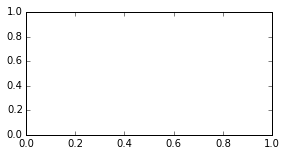

In [39]:
# ---------------------------------------------------------------
# Process diffusion tensor standard measures and plot
# ---------------------------------------------------------------

evals = fw_params[..., :3]

f = fw_params[..., 12]
fa = dti.fractional_anisotropy(evals)
trace = np.sum(evals, axis=3)

df2 = np.square(f - F)
dfa2 = np.square(fa - FA)
dtrace2 = np.square(trace - TRACE)

msef = np.sum(df2, axis=2) / (nrep*nDTdirs)
msefa = np.sum(dfa2, axis=2) / (nrep*nDTdirs)
msetrace = np.sum(dtrace2, axis=2) / (nrep*nDTdirs)

# Reciprocal scaled
rmsef = 1 - (msef-np.min(msef)) / (np.max(msef)-np.min(msef))
rmsefa = 1 - (msefa-np.min(msefa)) / (np.max(msefa)-np.min(msefa))
rmsetrace = 1 - (msetrace-np.min(msetrace)) / (np.max(msetrace)-np.min(msetrace))

# plot
Bmax, Bmin = np.meshgrid(bmax, bmin)
fig = plt.figure(figsize = (15, 2.2))
fig.subplots_adjust(wspace=0.2)

plt.subplot(1, 3, 1)
plt.pcolormesh(Bmax, Bmin, rmsef, cmap='Reds')
plt.axis([300, 1500, 800, 200])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

plt.subplot(1, 3, 2)
plt.pcolormesh(Bmax, Bmin, rmsefa, cmap='Reds')
plt.axis([300, 1500, 800, 200])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

plt.subplot(1, 3, 3)
plt.pcolormesh(Bmax, Bmin, rmsetrace, cmap='Reds')
plt.axis([300, 1500, 800, 200])
plt.colorbar()
plt.xlabel('Maxinum b-value (s/mm2)')
plt.ylabel('Mininum b-value (s/mm2)')

plt.show()